In [1]:
from keypress_recognition.models import black_key_model as bmodel
from keypress_recognition import dataset_p as dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
dataset.load_all_data(color=['black'], size=['single'], keypress=True)

Start seperating keyboard ...
  White single width: 21px
  Black single width: 20px
  White bundle width: 37px
  Black bundle width: 36px


IntProgress(value=0, max=14273)

In trainset: 
  # of pressed black key: 8755
  # of unpressed black key: 43913


IntProgress(value=0, max=5000)

In testset: 
  # of pressed black key: 761
  # of unpressed black key: 22462


IntProgress(value=0, max=2993)

In valset: 
  # of pressed black key: 817
  # of unpressed black key: 10718


In [51]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Y" if note else "N")
visualize_keys(True)

'Y'

Samples from X_train: 


IntProgress(value=0, max=87826)

(2, 106, 20, 3)
1 0
Samples from X_test: 


IntProgress(value=0, max=44924)

(2, 106, 20, 3)
1 0
Samples from X_val: 


IntProgress(value=0, max=21436)

(2, 106, 20, 3)
1 0


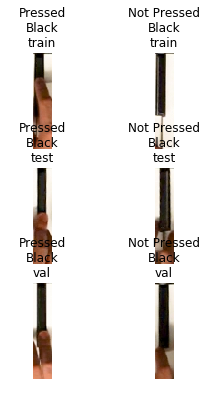

In [4]:
# print several images with labels
fig, axarr = plt.subplots(3, 2, figsize=[4, 6])
for ii, _type in enumerate(['train', 'test', 'val']):

    print(f'Samples from X_{_type}: ')

    for imgb, noteb in dataset.data_batch(type=_type, size='single', color='black', batch_size=2, NCHW=False, need_velocity=False):
        print(imgb.shape)
        print(noteb[0], noteb[1])
        axarr[ii,0].imshow(cv2.cvtColor(imgb[0], cv2.COLOR_BGR2RGB))
        axarr[ii,0].set_title(visualize_keys(noteb[0]) + '\nBlack\n' + _type)
        axarr[ii,0].axis('off')
        axarr[ii,1].imshow(cv2.cvtColor(imgb[1], cv2.COLOR_BGR2RGB))
        axarr[ii,1].set_title(visualize_keys(noteb[1]) + '\nBlack\n' + _type)
        axarr[ii,1].axis('off')
        break

plt.show()

In [23]:
bmodel.train(dataset, batch_size=32, size='single', color='black',
             num_epochs=10,
             max_num=100,
             learning_rate=1e-4,
             best_path='keypress_recognition/best_black_model.tar',
             current_path='keypress_recognition/current_black.tar',
             method=0)

Epoch 1/10


IntProgress(value=0)

train Loss: 0.3813
[[48  3]
 [16 61]]
Precision: 0.79
Recall   : 0.95


IntProgress(value=0, max=21436)

val Loss: 0.1244
[[ 9755   419]
 [  965 10301]]
Precision: 0.91
Recall   : 0.96
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 2/10


IntProgress(value=0)

train Loss: 0.2076
[[54  2]
 [10 62]]
Precision: 0.86
Recall   : 0.97


IntProgress(value=0, max=21436)

val Loss: 0.1241
[[ 9755   407]
 [  965 10313]]
Precision: 0.91
Recall   : 0.96
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 3/10


IntProgress(value=0)

train Loss: 0.0600
[[61  0]
 [ 3 64]]
Precision: 0.96
Recall   : 1.00


IntProgress(value=0, max=21436)

val Loss: 0.1241
[[ 9719   394]
 [ 1001 10326]]
Precision: 0.91
Recall   : 0.96
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 4/10


IntProgress(value=0)

train Loss: 0.1504
[[57  1]
 [ 7 63]]
Precision: 0.90
Recall   : 0.98


IntProgress(value=0, max=21436)

val Loss: 0.1230
[[ 9675   328]
 [ 1045 10392]]
Precision: 0.91
Recall   : 0.97
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 5/10


IntProgress(value=0)

train Loss: 0.2965
[[50  2]
 [14 62]]
Precision: 0.82
Recall   : 0.97


IntProgress(value=0, max=21436)

val Loss: 0.1242
[[ 9672   342]
 [ 1048 10378]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 6/10


IntProgress(value=0)

train Loss: 0.1920
[[55  2]
 [ 9 62]]
Precision: 0.87
Recall   : 0.97


IntProgress(value=0, max=21436)

val Loss: 0.1253
[[ 9663   329]
 [ 1057 10391]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 7/10


IntProgress(value=0)

train Loss: 0.4208
[[49  6]
 [15 58]]
Precision: 0.79
Recall   : 0.91


IntProgress(value=0, max=21436)

val Loss: 0.1252
[[ 9658   329]
 [ 1062 10391]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 8/10


IntProgress(value=0)

train Loss: 0.2799
[[52  2]
 [12 62]]
Precision: 0.84
Recall   : 0.97


IntProgress(value=0, max=21436)

val Loss: 0.1253
[[ 9664   344]
 [ 1056 10376]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 9/10


IntProgress(value=0)

train Loss: 0.3471
[[52  5]
 [12 59]]
Precision: 0.83
Recall   : 0.92


IntProgress(value=0, max=21436)

val Loss: 0.1246
[[ 9682   341]
 [ 1038 10379]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 10/10


IntProgress(value=0)

train Loss: 0.2228
[[52  1]
 [12 63]]
Precision: 0.84
Recall   : 0.98


IntProgress(value=0, max=21436)

val Loss: 0.1236
[[ 9695   340]
 [ 1025 10380]]
Precision: 0.91
Recall   : 0.97
Current mode has been saved to keypress_recognition/current_black.tar ...

Training complete in 1m 7s
Best val loss: 0.122962


IntProgress(value=0, max=44924)

(12, 106, 20, 3)
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)


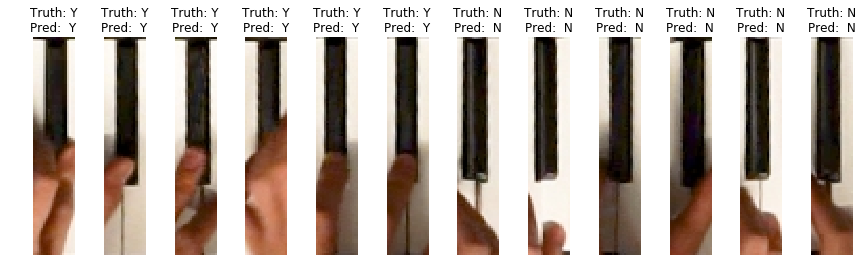

In [53]:
example_batch = 12
fig, axarr = plt.subplots(1, example_batch, figsize=(15,4))
for imgb, noteb in dataset.data_batch(type='test', size='single', color='black', batch_size=example_batch, NCHW=True, need_velocity=False):
    yb = bmodel.evaluate(imgb, threshold=0.5)
    imgb = np.transpose(imgb, (0, 2, 3, 1))
    print(imgb.shape)
    print(yb)
    for i in range(example_batch):
        axarr[i].imshow(cv2.cvtColor(imgb[i], cv2.COLOR_BGR2RGB))
        axarr[i].set_title('Truth: ' + visualize_keys(noteb[i]) + '\nPred:  ' + visualize_keys(yb[i]))
        axarr[i].axis('off')
    break
plt.show()